## Теоретическая часть

1. Вспомним прошлый вебинар, мы рассматривали User-User рекомендации и Item-Item рекомендации. Чем они отличаются и чем они похожи? Если есть функция item_item_rec(interaction_matrix). Можно ли использовать эту функцию для user_user_rec?  
В чем принципиальные отличия item-item рекомендаций от ALS?


**Ответ**  
а. Отличия в объекте, с которым работаем. Для User мы ищем других юзеров, чтоюы на основании их предпочтений выдать рекомендации, в item-based мы смотрим на другие товары, оцененные тем же пользователем. 
Общее - логика работы. Но для item based желательно учитывать характер поведения польхователя (для одних юзеров низкая оценка является более информаимвной, чем высокая и наоборот).
б. При условии совпадения всех прочих параметров, использование возможно ввиду похожей логики работы для обоих типов рекомендаций.  
в. ALS - использует разложение матриц и градиентный спуск.

2. Приведите 3 примера весов (те, которых не было на вебинаре: сумма покупок, количество покупок - неинтересно) user-item матрицы для задачи рекомендаций товаров 


**Ответ**
Возможные варианты поправочных коэфициентов/весов:  
- популярность товара в зависимости от сезона/даты/номера дня в году
- популярность покупок товара за цену с дисконтом оносительно объема продаж за базовую цену
- учет характера использования товара (товары длительного пользования относительно товаров, которые нуждаются в периодической покупке).

Возможно рассмотривать в качестве источника для рекомендательной системы не только покупки, но и промежуточные действия, каждое со своим колэффициентом.

3. Какие ограничения есть у ALS? (Тип информации, линейность/нелинейность факторов и т д)


## Практическая часть


In [3]:
#!pip install implicit

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Для работы с матрицами
from scipy.sparse import csr_matrix

# Матричная факторизация
from implicit.als import AlternatingLeastSquares
from implicit.nearest_neighbours import bm25_weight, tfidf_weight

# Функции из 1-ого вебинара
import os, sys


In [20]:
#from google.colab import drive
#drive.mount('/content/drive')
#root = '/content/drive/My Drive/GB/RecSys/webinar_2/'

In [21]:
#data = pd.read_csv(root+'retail_train.csv')
data = pd.read_csv('retail_train.csv')

data.columns = [col.lower() for col in data.columns]
data.rename(columns={'household_key': 'user_id',
                    'product_id': 'item_id'},
           inplace=True)


test_size_weeks = 3

data_train = data[data['week_no'] < data['week_no'].max() - test_size_weeks]
data_test = data[data['week_no'] >= data['week_no'].max() - test_size_weeks]

data_train.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.6,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.0,1631,1,0.0,0.0


In [22]:
popularity = data_train.groupby('item_id')['quantity'].sum().reset_index()
popularity.rename(columns={'quantity': 'n_sold'}, inplace=True)

top_5000 = popularity.sort_values('n_sold', ascending=False).head(5000).item_id.tolist()

# Заведем фиктивный item_id (если юзер покупал товары из топ-5000, то он "купил" такой товар)
data_train.loc[~data_train['item_id'].isin(top_5000), 'item_id'] = 999999

c:\users\пк\appdata\local\programs\python\python39\lib\site-packages\pandas\core\indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [23]:
user_item_matrix = pd.pivot_table(data_train, 
                                  index='user_id', columns='item_id', 
                                  values='quantity', # Можно пробоват другие варианты
                                  aggfunc='count', 
                                  fill_value=0
                                 )

In [24]:
user_item_matrix = user_item_matrix.astype(float)

In [25]:
user_item_matrix

item_id,202291,397896,420647,480014,545926,707683,731106,818980,819063,819227,...,15778533,15831255,15926712,15926775,15926844,15926886,15927403,15927661,15927850,16809471
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2496,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2497,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2498,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [26]:
sparse_user_item = csr_matrix(user_item_matrix).tocsr()

In [27]:
result = data_train.groupby('user_id')['item_id'].unique().reset_index()

In [28]:
result

,user_id,item_id
0,1,"[999999, 840361, 845307, 852014, 856942, 91267..."
1,2,"[854852, 930118, 1077555, 1098066, 999999, 556..."
2,3,"[866211, 878996, 882830, 904360, 921345, 99999..."
3,4,"[999999, 857849, 883932, 891423, 897125, 90103..."
4,5,"[999999, 889509, 937626, 941797, 1004596, 1114..."
...,...,...
2494,2496,"[840361, 999999, 871756, 886703, 899624, 91612..."
2495,2497,"[999999, 1037840, 5569230, 8090537, 1022428, 5..."
2496,2498,"[824555, 835576, 901776, 904023, 911215, 91749..."
2497,2499,"[838186, 999999, 864143, 932949, 933835, 10676..."


### Подбор матрицы $c_{ui}$
Попробуйте различные варианты матрицы весов (3+ вариантов). Обучите алгоритм для различных $C$. В качестве результата приведите таблицу: матрица весов - результат на train и validation.
Сделате качественные выводы.


*Взвешивание при помощи TF-IDF*

In [29]:
user_item_matrix_tf = tfidf_weight(user_item_matrix.T).T

In [30]:
user_item_matrix_tf

<2499x5001 sparse matrix of type '<class 'numpy.float64'>'
	with 667080 stored elements in COOrdinate format>

*Взвешивание при помощи BM25*

In [31]:
user_item_matrix_bm = bm25_weight(user_item_matrix.T).T 

In [32]:
user_item_matrix_bm

<2499x5001 sparse matrix of type '<class 'numpy.float64'>'
	with 667080 stored elements in COOrdinate format>

Процессинг будет осуществляться по очереди, для каждой из матриц.
Несмотря на то, что данные должны совпадать, будем выполнять подготовительные работы раздельно.

In [35]:
userids = user_item_matrix.index.values

In [36]:
itemids = user_item_matrix.columns.values

In [37]:
matrix_userids = np.arange(len(userids))
matrix_itemids = np.arange(len(itemids))

id_to_itemid = dict(zip(matrix_itemids, itemids))
id_to_userid = dict(zip(matrix_userids, userids))

itemid_to_id = dict(zip(itemids, matrix_itemids))
userid_to_id = dict(zip(userids, matrix_userids))

In [45]:
def precision_at_k(recommended_list, bought_list, k=5):
    
    bought_list = np.array(bought_list)
    recommended_list = np.array(recommended_list)
    
    bought_list = bought_list  # Тут нет [:k] !!
    recommended_list = recommended_list[:k]
    
    flags = np.isin(bought_list, recommended_list)
    
    precision = flags.sum() / len(recommended_list)
    
    
    return precision

In [42]:
def get_recommendations(user, model, N=5):
    res = [id_to_itemid[rec[0]] for rec in 
                    model.recommend(userid=userid_to_id[user], 
                                    user_items=sparse_user_item,   # на вход user-item matrix
                                    N=N, 
                                    filter_already_liked_items=False, 
                                    filter_items=[itemid_to_id[999999]], 
                                    recalculate_user=True)]
    return res

*Без применения весов*

In [59]:
%%time

model = AlternatingLeastSquares(factors=44, 
                                regularization=0.001,
                                iterations=15, 
                                calculate_training_loss=True, 
                                use_gpu=False)

Wall time: 0 ns


In [60]:
%time
model.fit(csr_matrix(user_item_matrix).T.tocsr(),  # На вход item-user matrix
          show_progress=True)

Wall time: 0 ns


  0%|          | 0/15 [00:00<?, ?it/s]

In [61]:
%time
recs = model.recommend(userid=userid_to_id[2],  # userid - id от 0 до N
                        user_items=csr_matrix(user_item_matrix).tocsr(),   # на вход user-item matrix
                        N=5, # кол-во рекомендаций 
                        filter_already_liked_items=False, 
                        filter_items=None, 
                        recalculate_user=True)

Wall time: 0 ns


In [62]:
%%time
    
result['no_weights'] = result['user_id'].apply(lambda x: get_recommendations(x, model=model, N=5))

Wall time: 17.1 s


In [63]:
result.apply(lambda row: precision_at_k(row['no_weights'], row['item_id']), axis=1).mean()

0.7065226090436174

*TF-IDF*

In [38]:
%%time

model_tf = AlternatingLeastSquares(factors=44, 
                                regularization=0.001,
                                iterations=15, 
                                calculate_training_loss=True, 
                                use_gpu=False)

Wall time: 997 µs


In [39]:
%time
model_tf.fit(csr_matrix(user_item_matrix_tf).T.tocsr(),  # На вход item-user matrix
          show_progress=True)

Wall time: 0 ns


  0%|          | 0/15 [00:00<?, ?it/s]

In [41]:
%time
recs = model_tf.recommend(userid=userid_to_id[2],  # userid - id от 0 до N
                        user_items=csr_matrix(user_item_matrix_tf).tocsr(),   # на вход user-item matrix
                        N=5, # кол-во рекомендаций 
                        filter_already_liked_items=False, 
                        filter_items=None, 
                        recalculate_user=True)

Wall time: 0 ns


In [43]:
%%time
    
result['tf'] = result['user_id'].apply(lambda x: get_recommendations(x, model=model_tf, N=5))

Wall time: 16.5 s


In [48]:
result.head(5)

,user_id,item_id,tf
0,1,"[999999, 840361, 845307, 852014, 856942, 91267...","[1100972, 5569374, 1082185, 995242, 1024306]"
1,2,"[854852, 930118, 1077555, 1098066, 999999, 556...","[1082185, 995242, 1133018, 5569230, 1106523]"
2,3,"[866211, 878996, 882830, 904360, 921345, 99999...","[951590, 1029743, 1092026, 1082185, 910032]"
3,4,"[999999, 857849, 883932, 891423, 897125, 90103...","[1082185, 1029743, 995242, 6534178, 981760]"
4,5,"[999999, 889509, 937626, 941797, 1004596, 1114...","[1082185, 6534178, 1029743, 995242, 981760]"


In [47]:
result.apply(lambda row: precision_at_k(row['tf'], row['item_id']), axis=1).mean()

0.6861944777911164

*****************************************************************************************************
*BM25*

In [49]:
%%time

model_bm = AlternatingLeastSquares(factors=44, 
                                regularization=0.001,
                                iterations=15, 
                                calculate_training_loss=True, 
                                use_gpu=False)

Wall time: 0 ns


In [50]:
%time
model_bm.fit(csr_matrix(user_item_matrix_bm).T.tocsr(),  # На вход item-user matrix
          show_progress=True)

Wall time: 0 ns


  0%|          | 0/15 [00:00<?, ?it/s]

In [52]:
%time
recs_bm = model_bm.recommend(userid=userid_to_id[2],  # userid - id от 0 до N
                        user_items=csr_matrix(user_item_matrix_bm).tocsr(),   # на вход user-item matrix
                        N=5, # кол-во рекомендаций 
                        filter_already_liked_items=False, 
                        filter_items=None, 
                        recalculate_user=True)

Wall time: 0 ns


In [53]:
%%time
    
result['bm'] = result['user_id'].apply(lambda x: get_recommendations(x, model=model_bm, N=5))

Wall time: 17 s


In [54]:
result.apply(lambda row: precision_at_k(row['bm'], row['item_id']), axis=1).mean()

0.6970788315326131

**Выводы**  
По результатам, показанным при помощи функции precision_at_k применение весов вообще без помощи алгоритмов взвешивания показывает наиболее высокие результаты.  
Возможно причина, в конкретном датасете.  
Т.е. использование весов вовсе не гарантирует сколько-нибудь внятный реультат.


### Оптимизация гипперпараметров
Для лучшей матрицы весов из первого задания подберите оптимальные $\lambda$ и n_factors. Подбор можно делать вручную (цикл в цикле, аналог sklearn.GridSearch, или случайно - sklearn.RandomSearch). Или Вы можете воспользоваться библиотеками для автоматического подбора гипперпараметров (любые на Ваш вкус). В качестве результата постройте графики:
1. Значение параметра - время обучения 
2. Значение параметра - качество train, качество validation  

Сделайте качественные выводы

In [55]:
import datetime

In [2]:
search_results = []

In [86]:
lambda_reg = np.logspace(-8, -2, 12) 
n_factors = np.linspace(10, 100, 10)

In [57]:
def get_recommendations(user, model, N=5):
    res = [id_to_itemid[rec[0]] for rec in 
                    model.recommend(userid=userid_to_id[user], 
                                    user_items=sparse_user_item,   # на вход user-item matrix
                                    N=N, 
                                    filter_already_liked_items=False, 
                                    filter_items=[itemid_to_id[999999]], 
                                    recalculate_user=True)]
    return res

Т.к. модель с использованием веслв для BM  показала большую эффективность, то будем подбирать гиперпараметры на ее основе.

In [77]:
def model_eval(model,user_item_matrix, result):
    
    model.fit(csr_matrix(user_item_matrix).T.tocsr(), show_progress=False)
    recs = model.recommend(userid=userid_to_id[2],  # userid - id от 0 до N
                        user_items=csr_matrix(user_item_matrix).tocsr(),   # на вход user-item matrix
                        N=5, # кол-во рекомендаций 
                        filter_already_liked_items=False, 
                        filter_items=None, 
                        recalculate_user=True)
    result['temp'] = result['user_id'].apply(lambda x: get_recommendations(x, model=model, N=5))
    precision = result.apply(lambda row: precision_at_k(row['temp'], row['item_id']), axis=1).mean()
    
    return precision
    
   

In [87]:
lambda_reg

array([1.00000000e-08, 3.51119173e-08, 1.23284674e-07, 4.32876128e-07,
       1.51991108e-06, 5.33669923e-06, 1.87381742e-05, 6.57933225e-05,
       2.31012970e-04, 8.11130831e-04, 2.84803587e-03, 1.00000000e-02])

In [89]:
n_factors = n_factors.astype(int)

In [90]:
n_factors

array([ 10,  20,  30,  40,  50,  60,  70,  80,  90, 100])

In [91]:
%time
search_reasults = []
for factor in n_factors:
    for lambda_val in lambda_reg:
        start_time = datetime.datetime.now().timestamp()
        
        model = AlternatingLeastSquares(factors=factor, 
                                regularization=lambda_val,
                                iterations=15, 
                                calculate_training_loss=True, 
                                use_gpu=False)
        
        presision_train = model_eval(model,user_item_matrix, result)
        
        end_time = datetime.datetime.now().timestamp()
              
        
        search_reasults.append([factor, 
                                lambda_val, 
                                start_time, 
                                end_time, 
                                presision_train])

Wall time: 0 ns


In [92]:
final_set = []
best = 0
for elem in search_reasults:
    if elem[4] > best:
        final_set = elem

In [93]:
final_set

[100, 0.01, 1645478696.051925, 1645478740.331603, 0.8170468187274911]

In [94]:
import seaborn as sns

In [99]:
df = pd.DataFrame(search_reasults, columns=['factor', 
                                'lambda_val', 
                                'start_time', 
                                'end_time', 
                                'presision_train'])
df.head()

,factor,lambda_val,start_time,end_time,presision_train
0,10,1.000000e-08,1.645475e+09,1.645475e+09,0.618567
1,10,3.511192e-08,1.645475e+09,1.645475e+09,0.619368
2,10,1.232847e-07,1.645475e+09,1.645475e+09,0.618167
3,10,4.328761e-07,1.645475e+09,1.645475e+09,0.619128
4,10,1.519911e-06,1.645475e+09,1.645475e+09,0.617367


<AxesSubplot:xlabel='factor', ylabel='presision_train'>

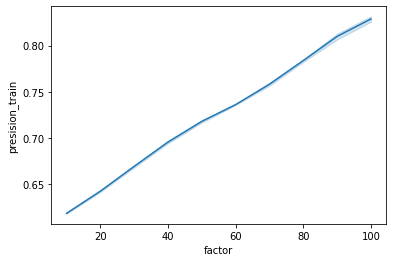

In [101]:
sns.lineplot(data=df, x='factor', y = 'presision_train')

In [107]:
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'lambda value dependency')

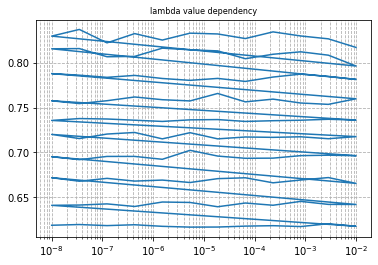

In [119]:
plt.plot(df['lambda_val'],df['presision_train'])
#plt.xlim(x_min,x_max)
#plt.ylim(np.exp(x_min),np.exp(x_max))
plt.xscale('log')

plt.grid(True,which="both", linestyle='--')

plt.title('lambda value dependency', fontsize=8)

**Вывод**   
Все рекомендательные системы являются полностью неинтуитивным занятием весьма сомнительной эффективности.  
Ждя данного конкретного примера наблюдается линейная зависимость между количеством факторов и точностью предсказания.  
Для величины регуляризации такой зависимости нет и, судя по графику наблюдается более-менее равномерное заполнение.  

**P.S.** Не пишите отписки в качестве выводов. Мне интресены Ваши рассуждения, трудности, с которыми Вы сталкнулись и что-то, что Вас удивило. Если выводы контринтуитивны - напишите об этом, в этом нет ничего страшного!

In [ ]:
!pip install hyperopt

# Use hyperopt!